In [30]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from __future__ import annotations
from typing import Any, Callable, List, Optional, Tuple

import os
import sys
sys.path.append("../") # So we can use the coordination package

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from coordination.component.serialized_mass_spring_damper_component import SerializedMassSpringDamperComponent
from coordination.model.serial_argument_model import SerialArgumentModel, SerialArgumentSeries, SerialArgumentSamples
from coordination.model.mass_spring_damper_model import MassSpringDamperModel
from coordination.model.coordination_model import CoordinationPosteriorSamples

# Style

In [32]:
plt.style.use("seaborn-v0_8-darkgrid")
tex_fonts = {
    "axes.labelsize": 6,
    "font.size": 6,
    "legend.fontsize": 8,
    "xtick.labelsize": 4,
    "ytick.labelsize": 4,
    "axes.titlesize": 8,
}
plt.rcParams.update(tex_fonts)
plt.rc('pdf',fonttype = 42)
plt.rcParams['text.usetex'] = True

DOC = "neurips"

## Helper functions

In [33]:
WIDTH_DICT = {
    "neurips": 397.48,
}

def calculate_best_figure_dimensions(document_width: Union[str, float], scale=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    document_width: Union[str, float]
            Document textwidth or columnwidth in pts. Predefined strings are also acceptable.
    scale: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if isinstance(document_width, str):
        width_pt = WIDTH_DICT.get(document_width, None)
        if width_pt is None:
            raise Exception(f"Width {document_width} not supported. Available custom widths are {WIDTH_DICT}")
    else:
        width_pt = document_width

    # Width of figure (in pts)
    fig_width_pt = width_pt * scale

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** .5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt

    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in

# Constants

In [34]:
# Plot
COLORS_SPR = ["#137513", "#FF9090", "#13B2FF"]
COLORS_ARG = ["#FF9090", "#13B2FF"]
MUSTARD = "#BE9700"

# Reproducibility
SEED = 0

# Data 
T=100

# Spring model
NUM_SPRINGS=3
SPRING_CONSTANT=np.array([16, 8, 4])
MASS=np.ones(NUM_SPRINGS) * 10
DAMPING_COEF_SPR=np.zeros(NUM_SPRINGS)
DT_SPR=0.2 # time step size
INITIAL_STATE_SPR=np.array([[1, 0], [3, 0], [5, 0]])
SD_AA_SPR=0.1  # noise in the model evolution
SD_O_SPR=0.1   # noise in the measurement
SPRING_DEPENDENCIES=np.array([[1/2, 1/2], [1/2, 1/2], [1/2, 1/2]]) # Remove this later when weights get out of the equation

# Argument model 
NUM_SUBJECTS=2
SUBJECT_NAMES=["Bob", "Alice"]
FREQ=np.array([0.8, 0.2])
DAMPING_COEF_ARG=np.zeros(NUM_SUBJECTS)
DT_ARG=0.2 # time step size
INITIAL_STATE_ARG=np.array([[1, 0], [1, 0]])
SD_AA_ARG=0.1  # noise in the model evolution
SD_O_ARG=0.01  # noise in the measurement

# Inference
BURN_IN = 100
NUM_SAMPLES = 100
NUM_CHAINS = 2
NUTS_INIT_METHOD = "jitter+adapt_diag"
TARGET_ACCEPT = 0.9

# Model

## a) Spring

In [35]:
spring_model = MassSpringDamperModel(num_springs=NUM_SPRINGS,
                                     spring_constant=SPRING_CONSTANT,
                                     mass=MASS,
                                     damping_coefficient=DAMPING_COEF_SPR,
                                     dt=DT_SPR,
                                     self_dependent=True,
                                     sd_mean_uc0=1,
                                     sd_sd_uc=1,
                                     mean_mean_a0=np.zeros((NUM_SPRINGS, 2)),
                                     sd_mean_a0=np.ones((NUM_SPRINGS, 2)) * max(INITIAL_STATE_SPR[:, 0]),  # Maximum value among initial positions not to make hyperprior too tight
                                     sd_sd_aa=np.ones(1),
                                     a_mixture_weights=np.ones((NUM_SPRINGS, NUM_SPRINGS - 1)),
                                     sd_sd_o=np.ones(1),
                                     share_sd_aa_across_springs=True,
                                     share_sd_aa_across_features=True,  # same variance for position and speed
                                     share_sd_o_across_springs=True,    # same measurement noise for different springs
                                     share_sd_o_across_features=True)   # same measurement noise for position and speed                               

## b) Argument

In [ ]:
argument_model = SerialArgumentModel(num_subjects=NUM_SUBJECTS,
                                     frequency=FREQ,
                                     damping_coefficient=DAMPING_COEF_ARG,
                                     dt=DT_ARG,
                                     self_dependent=True,
                                     sd_mean_uc0=1,
                                     sd_sd_uc=1,
                                     mean_mean_a0=np.zeros((NUM_SUBJECTS, 2)),
                                     sd_mean_a0=np.ones((NUM_SUBJECTS, 2)) * max(INITIAL_STATE_ARG[:, 0]),
                                     sd_sd_aa=np.ones(1),
                                     sd_sd_o=np.ones(1),
                                     share_sd_aa_across_subjects=True,
                                     share_sd_aa_across_features=True,
                                     share_sd_o_across_subjects=True,
                                     share_sd_o_across_features=True)

# Synthetic Data

## Helper Functions

In [36]:
def plot_spring_data(ax: Any, data: np.ndarray, marker_size: int = 8, marker: str = "o", title: str = "", skip:int = 0):
    num_time_steps = data.shape[-1]
    
    tt = np.arange(num_time_steps)
    indices = np.arange(0,num_time_steps) 
    
    if skip > 1:
        # We might drop some points for better visualization
        indices = [i for i in indices if i == 0 or (i % skip) != 0]
    
    for s in range(NUM_SPRINGS):
        ax.scatter(tt[indices], data[s, 0][indices], label=f"Spring {s + 1}", s=marker_size, marker=marker, c=COLORS_SPR[s])
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position")
    
def plot_argument_data(ax: Any, data: ArgumentSeries, marker_size: int = 8, marker: str = "o", title: str = "", skip:int = 0):
    for s, name in enumerate(SUBJECT_NAMES):
        tt = np.array([t for t, subject in enumerate(data.subjects_in_time) if s == subject])
        indices = np.arange(0,len(tt),skip+1) # We might drop some points for better visualization
        ax.scatter(tt[indices], data.observation[0, tt][indices], label=name, s=marker_size, marker=marker, c=COLORS_ARG[s])
    ax.set_title(title)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Position")
    
def argument_samples_to_evidence(samples: SerialArgumentSamples) -> SerialArgumentSeries:
    return SerialArgumentSeries(subjects_in_time=samples.state.subjects[0],
                                prev_time_same_subject=samples.state.prev_time_same_subject[0],
                                prev_time_diff_subject=samples.state.prev_time_diff_subject[0],
                                observation=samples.observation.values[0])    

## a) Spring

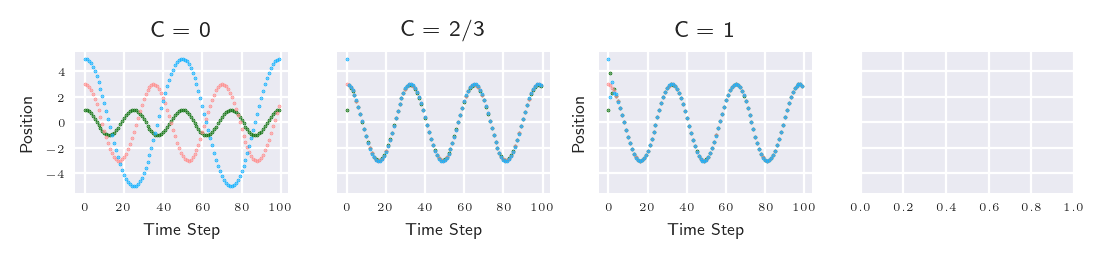

In [46]:
# Set parameters for data generation
spring_model.state_space_cpn.parameters.mean_a0.value=INITIAL_STATE_SPR
spring_model.state_space_cpn.parameters.sd_aa.value=np.zeros(1)  # only for plots
spring_model.observation_cpn.parameters.sd_o.value=np.zeros(1)

# Denoised version is only used for plots
T_plot = 20000
coordination = np.zeros((1, T_plot))
spring_uncoordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=SEED).observation.values[0]

coordination = np.ones((1, T_plot)) * 2/3
spring_coordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=SEED).observation.values[0]

coordination = np.ones((1, T_plot))
spring_supercoordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=SEED).observation.values[0]

# Noisy version for inference
spring_model.state_space_cpn.parameters.sd_aa.value=np.ones(1) * SD_AA_SPR
spring_model.observation_cpn.parameters.sd_o.value=np.ones(1) * SD_O_SPR

coordination = np.zeros((1, T))
noisy_spring_uncoordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=SEED).observation.values[0]

coordination = np.ones((1, T)) * 2/3
noisy_spring_coordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=SEED).observation.values[0]

coordination = np.ones((1, T))
noisy_spring_supercoordinated_data = spring_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=SEED).observation.values[0]

# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC, scale=2, subplots=(1,4))  
fig, axs = plt.subplots(1, 4, figsize=(w,h*1.5), sharey=True)

plot_spring_data(axs[0], spring_uncoordinated_data[..., 0:-1:20], marker_size=0.01, title=f"C = 0", skip=1)
plot_spring_data(axs[1], spring_coordinated_data[..., 0:-1:20], marker_size=0.01, title=f"C = 2/3", skip=1)
plot_spring_data(axs[2], spring_supercoordinated_data[..., 0:-1:20], marker_size=0.01, title=f"C = 1", skip=1)
axs[1].set_ylabel("")
plt.tight_layout()

## b) Argument

In [ ]:
# Set parameters for data generation
argument_model.state_space_cpn.parameters.mean_a0.value=INITIAL_STATE_ARG
argument_model.state_space_cpn.parameters.sd_aa.value=np.zeros(1)  # only for plots
argument_model.observation_cpn.parameters.sd_o.value=np.zeros(1)

# Denoised version is only used for plots
T_plot = 1000
coordination = np.zeros((1, T_plot))
argument_uncoordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=SEED))

coordination = np.ones((1, T_plot)) * 0.5
argument_coordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=SEED))

coordination = np.ones((1, T_plot))
argument_supercoordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T_plot, coordination_samples=coordination, seed=SEED))

# Noisy version for inference
argument_model.state_space_cpn.parameters.sd_aa.value=np.ones(1) * SD_AA_ARG
argument_model.observation_cpn.parameters.sd_o.value=np.ones(1) * SD_O_ARG

coordination = np.zeros((1, T))
noisy_argument_uncoordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=SEED))

coordination = np.ones((1, T)) * 0.5
noisy_argument_coordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=SEED))

coordination = np.ones((1, T))
noisy_argument_supercoordinated_data = argument_samples_to_evidence(argument_model.draw_samples(num_series=1, num_time_steps=T, coordination_samples=coordination, seed=SEED))

# Plot data
w, h = calculate_best_figure_dimensions(document_width=DOC, scale=1, subplots=(1,4))  
fig, axs = plt.subplots(1, 4, figsize=(w,h*1.5), sharey=True)

plot_argument_data(axs[0], argument_uncoordinated_data, marker_size=0.1, title=f"C = 0", skip=0)
plot_argument_data(axs[1], argument_coordinated_data, marker_size=0.1, title=f"C = 0.5", skip=0)
plot_argument_data(axs[2], argument_supercoordinated_data, marker_size=0.1, title=f"C = 1", skip=0)
axs[1].set_ylabel("")
plt.tight_layout()

# Experiments

## Helper Functions

In [ ]:
def train(model: Any, 
          evidence: Any, 
          init_method: str = "jitter+adapt_diag",
          burn_in: int = 1000, 
          num_samples: int = 1000, 
          num_chains: int = 2, 
          seed : int = 0):
    
    # Ignore PyMC warnings
    if not sys.warnoptions:
        import warnings
        warnings.simplefilter("ignore")
    
    # The environment variables below will make sure each chain does not take all the resources, slowing down inference.
    os.environ["MKL_NUM_THREADS"] = f"{NUM_CHAINS}"
    os.environ["OMP_NUM_THREADS"] = f"{NUM_CHAINS}"
    os.environ["OPENBLAS_NUM_THREADS"] = f"{NUM_CHAINS}"
    
    model.clear_parameter_values()  # so we can infer them
    _, idata = model.fit(evidence = evidence, 
                         init_method = init_method,
                         burn_in = burn_in, 
                         num_samples = num_samples, 
                         num_chains = num_chains,
                         seed = seed, 
                         num_jobs = num_chains)
    
    posterior_samples = CoordinationPosteriorSamples.from_inference_data(idata)
    
    # Plot parameter trace
    plot_parameter_trace(model, idata)

    # Plot coordination
    w, h = calculate_best_figure_dimensions(document_width=DOC, scale=1)  
    fig = plt.figure(figsize=(w,h))
    
    posterior_samples.plot(fig.gca(), show_samples=False, line_width=1)
    plt.title("Coordination")
    
    return posterior_samples, idata

def plot_parameter_trace(model: Any, idata: Any):
    sampled_vars = set(idata.posterior.data_vars)
    var_names = sorted(list(set(model.parameter_names).intersection(sampled_vars)))    
    az.plot_trace(idata, var_names=var_names)
    plt.tight_layout()

def build_convergence_summary(idata: Any) -> pd.DataFrame:
    header = [
        "variable",
        "mean_rhat",
        "std_rhat"
    ]
    
    rhat = az.rhat(idata)
    data = []
    for var, values in rhat.data_vars.items():
        entry = [
            var,
            values.to_numpy().mean(),
            values.to_numpy().std()
        ]
        data.append(entry)

    return pd.DataFrame(data, columns=header)

## 1) No Coordination

### 1.1) Spring

In [ ]:
evidence = noisy_spring_uncoordinated_data

c_posterior_spring_uncoordinated, idata_spring_uncoordinated = train(spring_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_spring_uncoordinated)

### 1.2) Argument

In [ ]:
evidence = noisy_argument_uncoordinated_data

c_posterior_argument_uncoordinated, idata_argument_uncoordinated = train(argument_model, evidence, burn_in=500, num_samples=500, num_chains=2, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_argument_uncoordinated)

## 2) Maximum Coordination

### 1.1) Spring

In [ ]:
evidence = noisy_spring_coordinated_data

c_posterior_spring_coordinated, idata_spring_coordinated = train(spring_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_spring_coordinated)

### 1.2) Argument

In [ ]:
evidence = noisy_argument_coordinated_data

c_posterior_argument_coordinated, idata_argument_coordinated = train(argument_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_argument_coordinated)

## 3) Supercoordination

### 3.1) Spring

In [ ]:
evidence = noisy_spring_supercoordinated_data

c_posterior_spring_supercoordinated, idata_spring_supercoordinated = train(spring_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_spring_supercoordinated)

### 3.2) Argument

In [ ]:
evidence = noisy_argument_supercoordinated_data

c_posterior_argument_supercoordinated, idata_argument_supercoordinated = train(argument_model, evidence, burn_in=BURN_IN, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, init_method=NUTS_INIT_METHOD)
build_convergence_summary(idata_argument_supercoordinated)

# Paper Plots

## a) Spring

In [ ]:
w, h = calculate_best_figure_dimensions(document_width=DOC, scale=1, subplots=(1,4))  
fig, axs = plt.subplots(1, 4, figsize=(w, h*1.5))
axs[1].sharey(axs[0])
axs[2].sharey(axs[0])

marker_size=0.05

# Data plots
plot_spring_data(axs[0], spring_uncoordinated_data[..., 0:-1:20], marker_size=marker_size, skip=1)
axs[0].set_ylabel("Spring Position")
axs[0].set_xlabel("Time Step")
axs[0].set_title("Data (c = 0)")

plot_spring_data(axs[1], spring_coordinated_data[..., 0:-1:20], marker_size=marker_size, skip=1)
axs[1].set_ylabel("")
axs[1].set_xlabel("Time Step")
axs[1].set_title("Data (c = 2/3)")

plot_spring_data(axs[2], spring_supercoordinated_data[..., 0:-1:20], marker_size=marker_size, skip=1)
axs[2].set_ylabel("")
axs[2].set_xlabel("Time Step")
axs[2].set_title("Data (c = 1)")

c_posterior_spring_uncoordinated.plot(axs[3], show_samples=False, line_width=0.5, color="tab:red", label="c = 0")
c_posterior_spring_coordinated.plot(axs[3], show_samples=False, line_width=0.5, color=MUSTARD, label="c = 2/3")
c_posterior_spring_supercoordinated.plot(axs[3], show_samples=False, line_width=0.5, color="tab:blue", label="c = 1")
axs[3].set_title("Inferred Coordination")
axs[3].set_xlabel("")
axs[3].set_ylabel("Coordination")
axs[3].set_xlabel("Time Step")

handles, labels = axs[0].get_legend_handles_labels()
handles_c, labels_c = axs[3].get_legend_handles_labels()
handles.extend(handles_c)
labels.extend(labels_c)
leg = fig.legend(handles, labels, loc='upper center', ncol=7, bbox_to_anchor=[0.5, 1.2], frameon=True, markerscale=15, columnspacing=1.4)
for line in leg.get_lines():
    line.set_linewidth(1.5)

plt.tight_layout()
save_plot("results_spring_model", fig)

## b) Argument model

In [ ]:
w, h = calculate_best_figure_dimensions(document_width=DOC, scale=1, subplots=(1,4))  
fig, axs = plt.subplots(1, 4, figsize=(w, h*1.5))
axs[1].sharey(axs[0])
axs[2].sharey(axs[0])

marker_size=0.2

# Data plots
plot_argument_data(axs[0], argument_uncoordinated_data, marker_size=marker_size, skip=1)
axs[0].set_ylabel("Voice Intensity")
axs[0].set_xlabel("Time Step")
axs[0].set_title("Data (c = 0)")

plot_argument_data(axs[1], argument_coordinated_data, marker_size=marker_size, skip=1)
axs[1].set_ylabel("")
axs[1].set_xlabel("Time Step")
# axs[1].set_yticklabels([])
axs[1].set_title("Data (c = 0.5)")

plot_argument_data(axs[2], argument_supercoordinated_data, marker_size=marker_size, skip=1)
axs[2].set_ylabel("")
axs[2].set_xlabel("Time Step")
axs[2].set_title("Data (c = 1)")

c_posterior_argument_uncoordinated.plot(axs[3], show_samples=False, line_width=0.5, color="tab:red", label="c = 0")
c_posterior_argument_coordinated.plot(axs[3], show_samples=False, line_width=0.5, color=MUSTARD, label="c = 0.5")
c_posterior_argument_supercoordinated.plot(axs[3], show_samples=False, line_width=0.5, color="tab:blue", label="c = 1")
axs[3].set_title("Inferred Coordination")
axs[3].set_xlabel("")
axs[3].set_ylabel("Coordination")
axs[3].set_xlabel("Time Step")

handles, labels = axs[0].get_legend_handles_labels()
handles_c, labels_c = axs[3].get_legend_handles_labels()
handles.extend(handles_c)
labels.extend(labels_c)
leg = fig.legend(handles, labels, loc='upper center', ncol=6, bbox_to_anchor=[0.5, 1.2], frameon=True, markerscale=8, columnspacing=1.4)
for line in leg.get_lines():
    line.set_linewidth(1.5)

plt.tight_layout()
save_plot("results_argument_model", fig)